# Financial Mathematics 
### Lab 4: Variance reduction

The purpose of this class is to implement variance reduction methods: stratified sampling, importance sampling, control variates and other.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
import scipy.stats as stats

import warnings

warnings.filterwarnings("ignore")

np.random.seed(42)

### π estimation

Implementation idea outline:
- **classical approach**: we sample from square with corners in $(-1, -1), (1, -1), (1, 1), (-1, 1)$ and return fraction of points inside circle $x^2 + y^2 \leq 1$ multiplied by square area (4);
- **variance reduction: using domain knowledge**: we sample only from small part of the square, where the variance is significant - yellow part. In sampling process we omit areas, where variance is 0 (like green and orange).

<img src="img.png" alt="drawing" width="400"/>

$$ S_{\text{circle}} = S_{\text{green square}} + 8 \cdot S_{\text{yellow fragment}} = S_{\text{green square}} + 8 \cdot S_{\text{rectangle}} \cdot \frac{ \# \text{samples inside yellow fragment}}{\# \text{all samples in rectangle}}$$

We sample from rectangle with parameters: $x_{\text{min}} = \frac{\sqrt{2}}{2}r$, $x_{\text{max}} = r$, $y_{\text{min}} = 0$, $y_{\text{max}} =  \frac{\sqrt{2}}{2}r$.

*This solution reduces variance more than the one proposed in class (sample from one fourth of Big square - Small square).*

- **stratified sampling**: we recursively divide the square into smaller ones and use `budget` * `N` samples to estimate sigmas (variances in subregions). The recursion ends when there is below `min_samples` in subregion. We use sigmas to compute subregions' weights and sample `weight` * (1 -`budget`) * `N` samples from each subregion (each suregion has its own weight). Then we use it to estimate desired value.


In [2]:
def f(x: np.ndarray, y: np.ndarray, radius) -> np.ndarray:
    return np.array([x ** 2 + y ** 2 <= radius ** 2]) * 1

In [ ]:
class PiEstimator:
    """
    A class to estimate the value of Pi using various sampling methods.
    """

    def __init__(self, radius: float):
        """
        Initializes the PiEstimator with a given radius.

        Args:
            radius (float): The radius of the circle.
        """
        self.radius = radius
        self.classical_samples_x = []
        self.classical_samples_y = []
        self.domain_samples_x = []
        self.domain_samples_y = []
        self.stratified_samples_x = []
        self.stratified_samples_y = []

    def classical_estimate(self, n: int) -> float:
        """
        Estimates Pi using classical Monte Carlo sampling.

        Args:
            n (int): Number of samples.

        Returns:
            float: Estimated value of Pi.
        """
        x = np.random.uniform(-1, 1, n)
        y = np.random.uniform(-1, 1, n)
        count = np.sum(x ** 2 + y ** 2 <= 1) 
        
        res = count * 4 / n
        
        self.classical_samples_x = x
        self.classical_samples_y = y
        
        return res
    
    def vr_domain_estimate(self, n: int) -> float:
        """
        Estimates Pi using variance reduction domain sampling.

        Args:
            n (int): Number of samples.

        Returns:
            float: Estimated value of Pi.
        """
        x = np.random.uniform(np.sqrt(2)/2, 1, n) * self.radius
        y = np.random.uniform(0, np.sqrt(2)/2, n) * self.radius
        
        mini_square_area = 2 * self.radius * self.radius
        rect_area = (np.sqrt(2)/2 - 0.5) * self.radius * self.radius
        
        count = np.sum(x ** 2 + y ** 2 <= self.radius ** 2) 
        res = mini_square_area + 8 * rect_area * count / n
        
        self.domain_samples_x = x
        self.domain_samples_y = y
        
        return res / (self.radius ** 2)
    
    def stratified_sampling_estimate(self, 
                                     N: int,
                                     budget: float = 0.2, 
                                     function: callable = f, 
                                     min_samples: int = 20,
                                     eps: float = 0.001,
                                     max_depth: int = 5,
                                     region: tuple = None
                                     ) -> float:
        """
        Estimates Pi using stratified sampling.

        Args:
            N (int): Total number of samples.
            budget (float): Fraction of samples used for variance estimation.
            function (callable): Function to evaluate.
            min_samples (int): Minimum samples per region.
            eps (float): Small value added to variance.
            max_depth (int): Maximum depth of recursion.
            region (tuple, optional): Region bounds.

        Returns:
            float: Estimated value of Pi.
        """
        N_var = int(budget * N)
        x_var = np.random.uniform(-self.radius, self.radius, N_var)
        y_var = np.random.uniform(-self.radius, self.radius, N_var)
        
        if region is None:
            region = ((-self.radius, self.radius), (-self.radius, self.radius))
            
        variances = self._estimate_variances_recursive(
            (x_var, y_var),
            region,
            min_samples,
            function = function,
            eps = eps,
            max_depth = max_depth
            
        )
    
        return self._estimate_pi(N = N - N_var, variances = variances, function = function)
    
    def _estimate_variances_recursive(self,
                                     samples: tuple, 
                                     region: tuple, 
                                     min_samples: int = 20, 
                                     depth: int = 0, 
                                     function: callable = f, 
                                     eps: float = 0.001, 
                                     max_depth: int = 5) -> dict:
        """
        Recursively estimates variances for stratified sampling.

        Args:
            samples (tuple): Tuple of x and y samples.
            region (tuple): Region bounds.
            min_samples (int): Minimum samples per region.
            depth (int): Current recursion depth.
            function (callable): Function to evaluate.
            eps (float): Small value added to variance.
            max_depth (int): Maximum depth of recursion.

        Returns:
            dict: Variances for each region.
        """
        x_min, x_max, y_min, y_max = region[0][0], region[0][1], region[1][0], region[1][1]
        x, y = samples
        f_xy = function(x, y, self.radius).flatten()
      
        # base case - not enough samples to divide number of samples in current region
        legal_samples = (x <= x_max) & (x >= x_min) & (y <= y_max) & (y >= y_min)
        x_region = x[legal_samples]
        y_region = y[legal_samples]
        n_samples = np.sum(legal_samples)
        
        if n_samples < min_samples or depth >= max_depth:        
            if n_samples > 1:
                f_values = function(x_region, y_region, self.radius).flatten()
                var = np.var(f_values) if len(f_values) > 1 else 0
            else:
                var = 0
            return {region: var + eps}
        
        x_mid = (x_min + x_max) / 2
        y_mid = (y_min + y_max) / 2
        
        subregions = [
            ((x_mid, x_max), (y_min, y_mid)),
            ((x_mid, x_max), (y_mid, y_max)),
            ((x_min, x_mid), (y_mid, y_max)),
            ((x_min, x_mid), (y_min, y_mid))
        ]
        
        # estimate variances recursively 
        variances = {}
        for subreg in subregions:
            subreg_var = self._estimate_variances_recursive(samples, subreg, min_samples, depth + 1, function, eps, max_depth)
            variances.update(subreg_var)
        
        return variances

    def _estimate_pi(self, N: int, variances: dict, function: callable = f) -> float:
        """
        Estimates Pi using stratified sampling and calculated variances.

        Args:
            N (int): Number of samples.
            variances (dict): Variances for each region.
            function (callable): Function to evaluate.

        Returns:
            float: Estimated value of Pi.
        """
        regions = list(variances.keys())
        std_devs = np.sqrt([variances[region] for region in regions])
        areas = np.array([(x_max - x_min) * (y_max - y_min) 
                        for ((x_min, x_max), (y_min, y_max)) in regions])
        
        std_dev_times_area = areas * std_devs 
        total_std_dev_times_area = np.sum(std_dev_times_area)
        weights = std_dev_times_area / total_std_dev_times_area
        
        n_samples_region = (N * weights).astype(int)
        n_samples_region[0] += N - np.sum(n_samples_region) # so that all samples are well used
        
        integral_estimate = 0.0
        
        for i, region in enumerate(regions):
            n = n_samples_region[i]
            
            if n == 0:
                continue
        
            (x_min, x_max), (y_min, y_max) = region
            x = np.random.uniform(x_min, x_max, n)
            y = np.random.uniform(y_min, y_max, n)
            f_xy = function(x, y, self.radius).flatten()
            
            self.stratified_samples_x = np.append(self.stratified_samples_x, x)
            self.stratified_samples_y = np.append(self.stratified_samples_y, y)
            
            area = (x_max - x_min) * (y_max - y_min)
            est = area * np.mean(f_xy) 
            integral_estimate += est
            
        pi_estimate = integral_estimate / (self.radius ** 2)
        return pi_estimate
    
    def classical_estimate_cumulative(self, n: int) -> np.ndarray:
        """
        Computes cumulative estimates of Pi using classical Monte Carlo sampling.

        Args:
            n (int): Number of samples.

        Returns:
            np.ndarray: Array of cumulative Pi estimates.
        """
        x = np.random.uniform(-1, 1, n)
        y = np.random.uniform(-1, 1, n)
        inside_circle = x ** 2 + y ** 2 <= 1
        cumulative_counts = np.cumsum(inside_circle)
        cumulative_estimates = 4 * cumulative_counts / np.arange(1, n + 1)
        
        return cumulative_estimates
    
    def vr_domain_estimate_cumulative(self, n: int) -> np.ndarray:
        """
        Computes cumulative estimates of Pi using variance reduction domain sampling.

        Args:
            n (int): Number of samples.

        Returns:
            np.ndarray: Array of cumulative Pi estimates.
        """
        x = np.random.uniform(np.sqrt(2)/2, 1, n) * self.radius
        y = np.random.uniform(0, np.sqrt(2)/2, n) * self.radius
        
        mini_square_area = 2 * self.radius * self.radius
        rect_area = (np.sqrt(2)/2 - 0.5) * self.radius * self.radius
        
        inside_circle = x ** 2 + y ** 2 <= self.radius ** 2
        cumulative_counts = np.cumsum(inside_circle)
        cumulative_estimates = mini_square_area + 8 * rect_area * cumulative_counts / np.arange(1, n + 1)
        
        return cumulative_estimates / (self.radius ** 2)
    
    def stratified_sampling_estimate_cumulative(self, 
                                                N: int,
                                                budget: float = 0.2, 
                                                function: callable = f, 
                                                min_samples: int = 20,
                                                eps: float = 0.001
                                                ) -> np.ndarray:
        """
        Computes cumulative estimates of Pi using stratified sampling.

        Args:
            N (int): Total number of samples.
            budget (float): Fraction of samples used for variance estimation.
            function (callable): Function to evaluate.
            min_samples (int): Minimum samples per region.
            eps (float): Small value added to variance.

        Returns:
            np.ndarray: Array of cumulative Pi estimates.
        """
        estimates = np.zeros(N)
        for i in range(N):
            estimates[i] = self.stratified_sampling_estimate(N = i + 1, budget = budget, function = function, min_samples = min_samples, eps = eps)
        
        res = np.cumsum(estimates) / np.arange(1, N + 1)
        return res
        
    def plot_stratified_samples_circle(self, circle: bool = True):
        """
        Plots the stratified sampling points within the circle.

        Args:
            circle (bool): Whether to plot the circle boundary.
        """
        if circle:
            circle = plt.Circle((0, 0), self.radius, color='red', fill=False, linewidth=2)
        
        plt.figure(figsize=(6,6))
        sns.scatterplot(x=self.stratified_samples_x, 
                y=self.stratified_samples_y, 
                color="royalblue",
                s = 0.5,
                alpha = 0.7)
        if circle:
            plt.gca().add_artist(circle)
        plt.title("Sampling in stratified method")
        plt.show()
        
    def plot_all_samples(self, circle: bool = True):
        """
        Plots all sampling points for classical, variance reduction, and stratified methods.

        Args:
            circle (bool): Whether to plot the circle boundary.
        """
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        
        circle = plt.Circle((0, 0), self.radius, color='navy', fill=False, linewidth=2)
        
        axs[0].scatter(self.classical_samples_x, self.classical_samples_y, color="royalblue", s=0.1, alpha=0.7)
        if circle:
            axs[0].add_artist(circle)
        axs[0].set_title("Classical Sampling")
        axs[0].set_xlim(-self.radius, self.radius)
        axs[0].set_ylim(-self.radius, self.radius)
        axs[0].set_aspect('equal', adjustable='box')
        
        circle = plt.Circle((0, 0), self.radius, color='navy', fill=False, linewidth=2)
        
        axs[1].scatter(self.domain_samples_x, self.domain_samples_y, color="darkorange", s=0.1, alpha=0.7)
        if circle: 
            axs[1].add_artist(circle)
        axs[1].set_title("Variance Reduction Domain Sampling")
        axs[1].set_xlim(-self.radius, self.radius)
        axs[1].set_ylim(-self.radius, self.radius)
        axs[1].set_aspect('equal', adjustable='box')
        
        circle = plt.Circle((0, 0), self.radius, color='navy', fill=False, linewidth=2)
        
        axs[2].scatter(self.stratified_samples_x, self.stratified_samples_y, color="forestgreen", s=0.1, alpha=0.7)
        if circle:
            axs[2].add_artist(circle)
        axs[2].set_title("Stratified Sampling")
        axs[2].set_xlim(-self.radius, self.radius)
        axs[2].set_ylim(-self.radius, self.radius)
        axs[2].set_aspect('equal', adjustable='box')
        
        plt.tight_layout()
        plt.show()

### Analysis

In [14]:
pi_estimator = PiEstimator(radius = 1)

In [12]:
def compare_and_plot_estimations(N: int):
    x = range(1, N+1)
    cl, vr, sf = [0] * N, [0] * N, [0] * N
    
    estimator = PiEstimator(radius = 1)
    
    for i in x:
        cl[i - 1] = estimator.classical_estimate(i)
        vr[i - 1] = estimator.vr_domain_estimate(i)
        sf[i - 1] = estimator.stratified_sampling_estimate_cumulative(i)[-1]
    
    plt.figure(figsize=(20,10))
    sns.lineplot(x = x, y = cl,label = "classical", alpha = 0.5);
    sns.lineplot(x = x, y = vr, label = "vr domain");
    sns.lineplot(x = x, y = sf, label = "stratified");
    plt.hlines(xmin = 1, xmax = N, y = np.pi, color = "red", label = "NumPy value");
    plt.ylim(np.pi + 1, np.pi - 1)
    plt.legend(title="Method")
    plt.show();

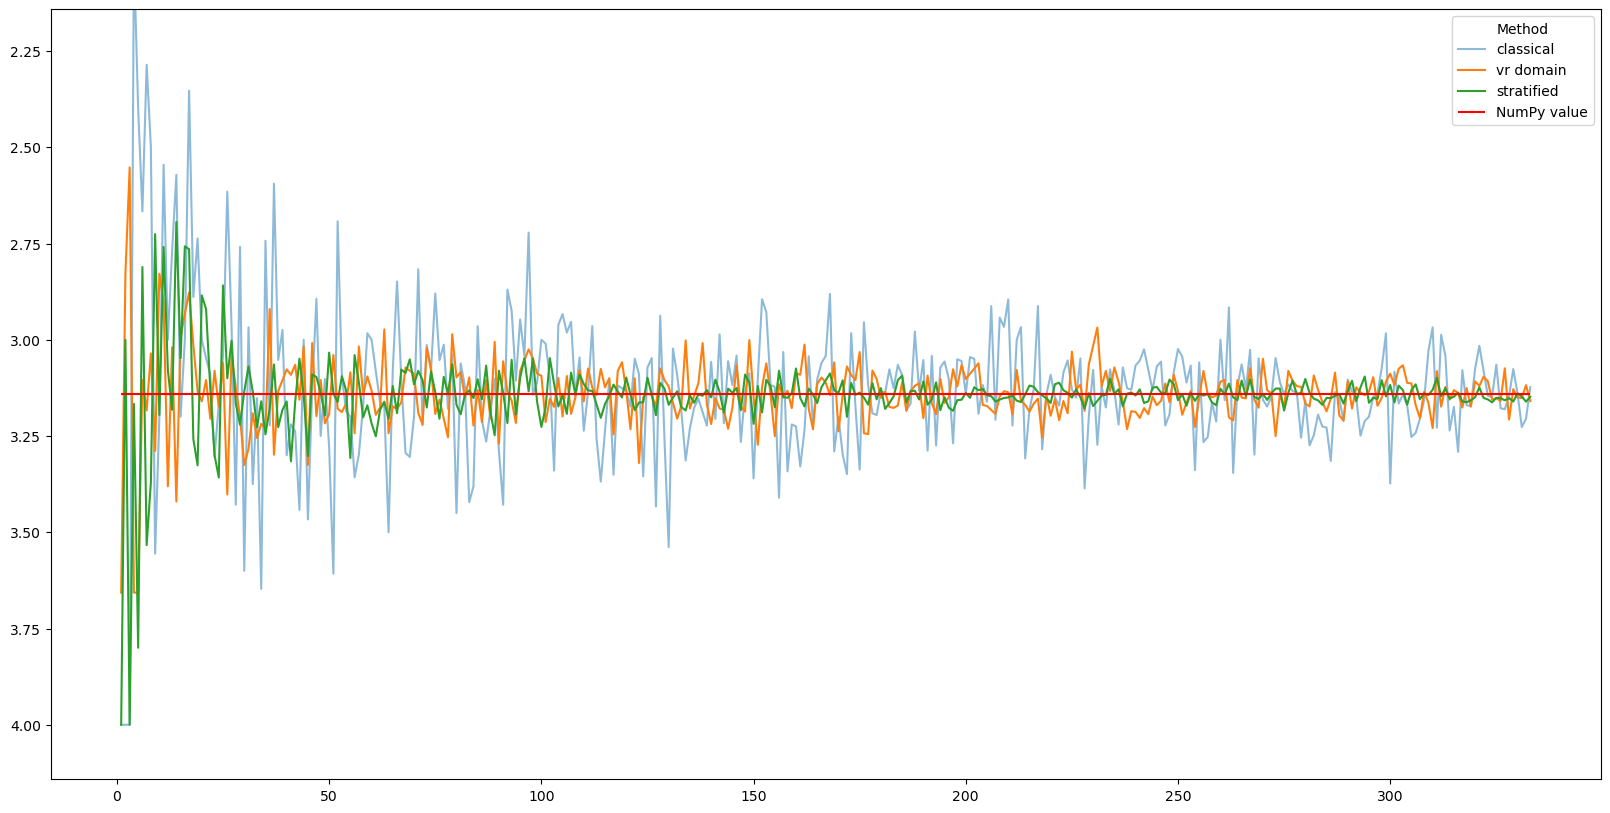

In [13]:
compare_and_plot_estimations(333)

It can be seen in the plot that stratified sampling has lower variance than domain knowledge method and the latter has lower variance than classical approach, in most cases. 

#### Empirical variances comparison

In [109]:
def compare_variance_boxplot(estimator: PiEstimator, n_trials: int, n_samples: int, eps: float = 0.001):
    classical_vals = [estimator.classical_estimate(n_samples) for _ in range(n_trials)]
    var_red_vals = [estimator.vr_domain_estimate(n_samples) for _ in range(n_trials)]
    stratified_vals = [estimator.stratified_sampling_estimate_cumulative(n_samples, eps=eps)[-1] for _ in range(n_trials)]

    data = pd.DataFrame({
        "Classical": classical_vals,
        "VR Domain": var_red_vals,
        "Stratified Sampling": stratified_vals
    })
    
    plt.figure(figsize=(10,6))
    sns.boxplot(data=data)
    plt.axhline(np.pi, linestyle="--", color="red", label="π (NumPy Value)")
    plt.title("Boxplot of results of π Estimators")
    plt.ylabel("Estimated π Value")
    plt.legend()
    plt.grid(True)
    plt.show()


/Users/gasparsekula/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


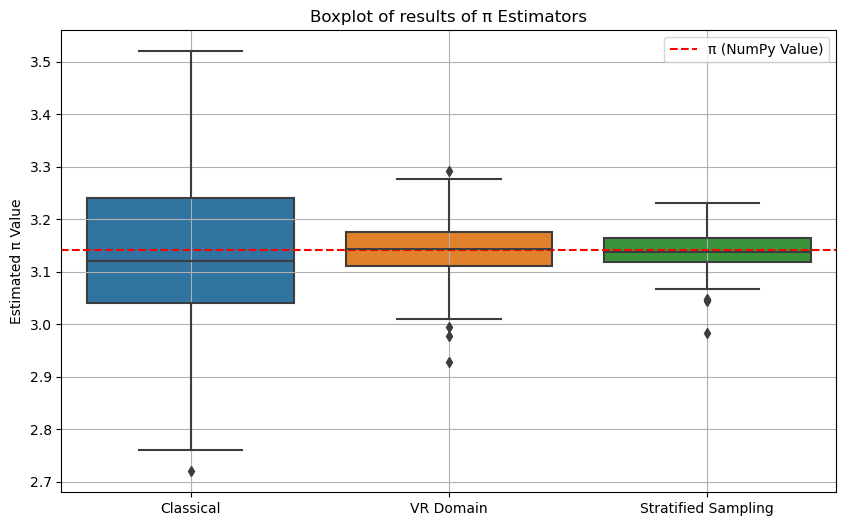

In [110]:
compare_variance_boxplot(pi_estimator, 100, 100)

The same trend is observed.

#### Estimations convergence

Here we analyze cumulative estimations.

In [111]:
def pad_to_length(arr: np.ndarray, target_len: int) -> np.ndarray:
    """Repeat last value to reach target_len."""
    if len(arr) == 0:
        return np.zeros(target_len)
    if len(arr) == target_len:
        return arr
    padded = np.full(target_len, arr[-1])
    padded[:len(arr)] = arr
    return padded

def plot_cumulative_convergence(estimator: PiEstimator, n: int):
    cum_classical = estimator.classical_estimate_cumulative(n)
    cum_var_red = estimator.vr_domain_estimate_cumulative(n)
    cum_strat = estimator.stratified_sampling_estimate_cumulative(n)

    plt.figure(figsize=(20,10))
    plt.plot(cum_classical, label="Classical")
    plt.plot(cum_var_red, label="VR Domain")
    plt.plot(cum_strat, label="Stratified Sampling")
    plt.axhline(np.pi, linestyle="--", color="black", label="π (NumPy Value)")
    plt.title("Cumulative Convergence of π Estimators")
    plt.xlabel("Number of Samples")
    plt.ylabel("Estimate")
    plt.ylim(np.pi - 0.5, np.pi + 0.5)
    plt.legend()
    plt.grid(True)
    plt.show()

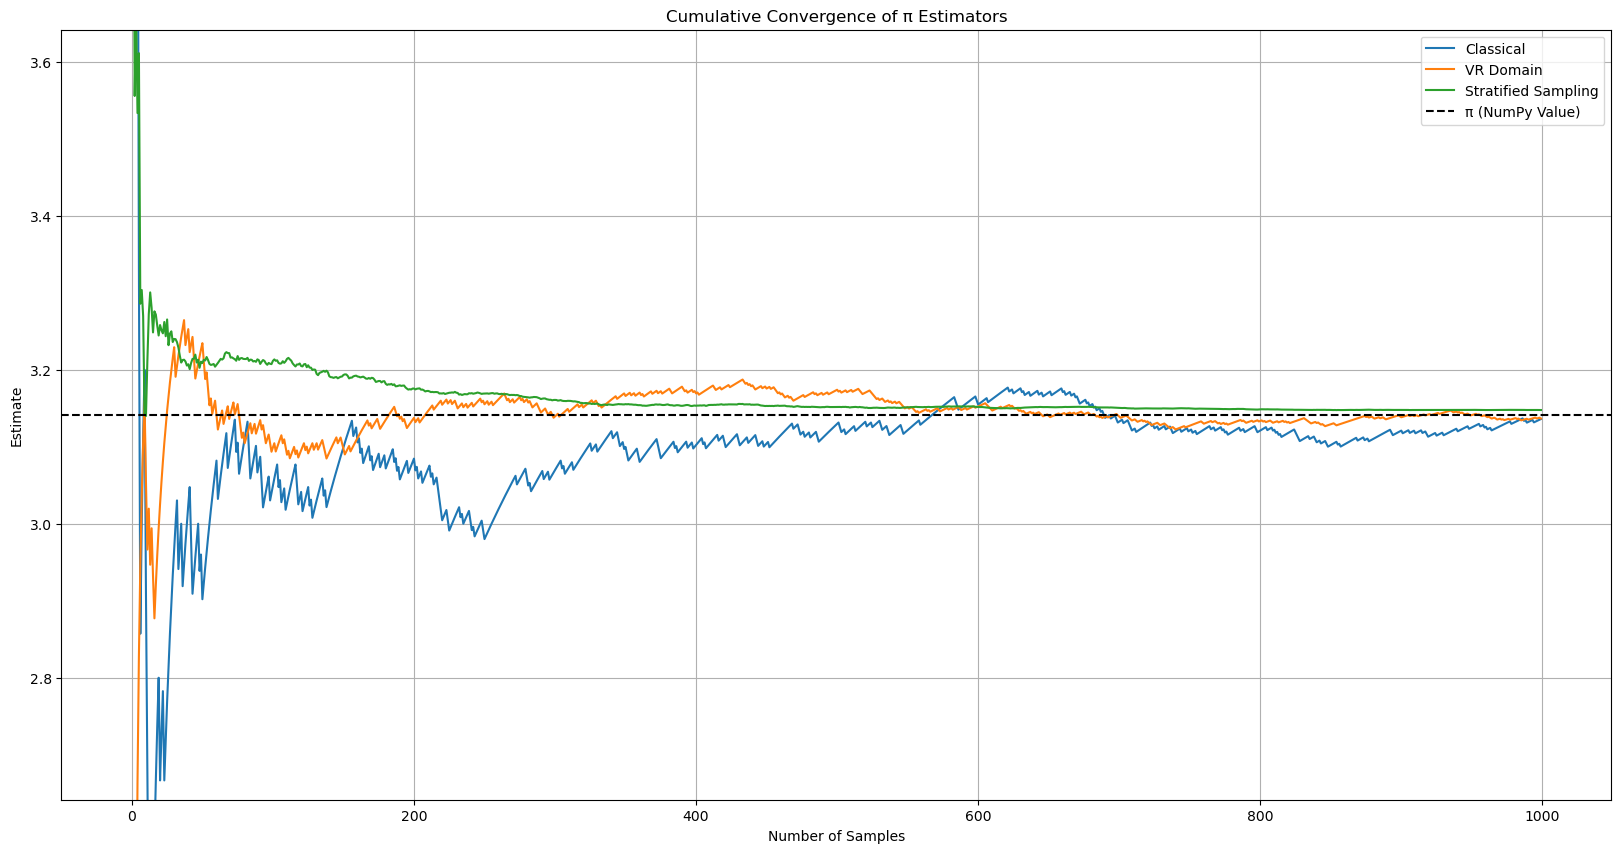

In [113]:
plot_cumulative_convergence(pi_estimator, 1000)

As we can see, the most stable method is the stratified sampling. Subsequently stands the domain knowledge approach.

#### Empirical standard deviations comparison

To prove the conclusion from last boxplot, let's investigate empirical standard deviations.

In [17]:
def plot_std_devs(estimator: PiEstimator, n_trials: int, n_samples: int, eps: float = 0.001):
    classical_vals = [estimator.classical_estimate(n_samples) for _ in range(n_trials)]
    var_red_vals = [estimator.vr_domain_estimate(n_samples) for _ in range(n_trials)]
    stratified_vals = [estimator.stratified_sampling_estimate_cumulative(n_samples, eps = eps)[-1] for _ in range(n_trials)]

    stds = [
        np.std(classical_vals),
        np.std(var_red_vals),
        np.std(stratified_vals)
    ]

    plt.figure(figsize=(8,5))
    plt.bar(["Classical", "VR Domain", "Stratified"], stds, color=["royalblue", "darkorange", "forestgreen"])
    plt.title("Standard Deviation of π Estimators")
    plt.ylabel("Standard Deviation")
    plt.grid(axis="y")
    plt.show()


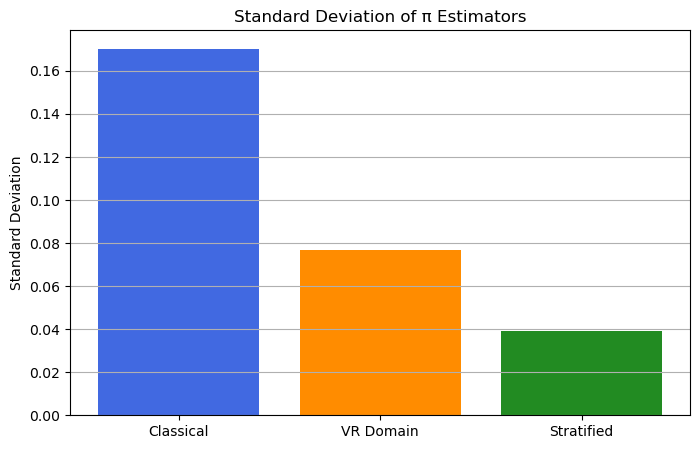

In [18]:
plot_std_devs(pi_estimator, 500, 100)

#### Confidence intervals

In [19]:
def compute_confidence_interval(estimates, confidence=0.95):
    n = len(estimates)
    mean = np.mean(estimates)
    std_err = stats.sem(estimates)
    h = std_err * stats.t.ppf((1 + confidence) / 2.0, n - 1)
    return mean, mean - h, mean + h

In [79]:
def plot_confidence_intervals(estimator: PiEstimator, n_trials=100, n_samples=100, confidence=0.95):
    classical = [estimator.classical_estimate(n_samples) for _ in range(n_trials)]
    var_red = [estimator.vr_domain_estimate(n_samples) for _ in range(n_trials)]
    strat = [estimator.stratified_sampling_estimate_cumulative(n_samples)[-1] for _ in range(n_trials)]

    ci_classical = compute_confidence_interval(classical, confidence)
    ci_var_red = compute_confidence_interval(var_red, confidence)
    ci_strat = compute_confidence_interval(strat, confidence)

    print(f"Classical: Lower = {ci_classical[1]:.4f}, Upper = {ci_classical[2]:.4f}, Width = {ci_classical[2] - ci_classical[1]:.4f}")
    print(f"VR Domain: Lower = {ci_var_red[1]:.4f}, Upper = {ci_var_red[2]:.4f}, Width = {ci_var_red[2] - ci_var_red[1]:.4f}")
    print(f"Stratified Sampling: Lower = {ci_strat[1]:.4f}, Upper = {ci_strat[2]:.4f}, Width = {ci_strat[2] - ci_strat[1]:.4f}")

    widths = [ci_classical[2] - ci_classical[1], ci_var_red[2] - ci_var_red[1], ci_strat[2] - ci_strat[1]]
    labels = ["Classical", "VR Domain", "Stratified Sampling"]
    
    plt.figure(figsize=(8, 5))
    plt.bar(labels, widths, color=['royalblue', 'darkorange', 'forestgreen'])
    plt.ylabel("Width of Confidence Interval")
    plt.title(f"Width of {int(confidence*100)}% Confidence Intervals for π Estimators ({n_trials} trials)")
    plt.grid(True, axis='y')
    plt.show()


Classical: Lower = 3.1206, Upper = 3.1834, Width = 0.0629
VR Domain: Lower = 3.1289, Upper = 3.1532, Width = 0.0243
Stratified Sampling: Lower = 3.1342, Upper = 3.1520, Width = 0.0178


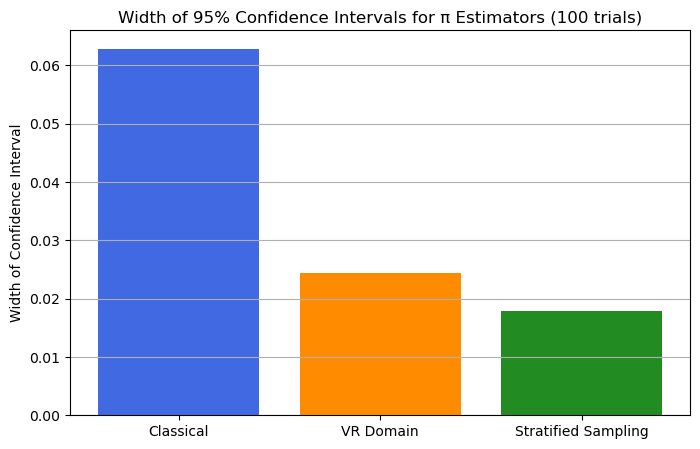

In [80]:
plot_confidence_intervals(pi_estimator)

Conclusions still the same...

#### Relative error vs. number of samples

In [83]:
def plot_relative_error(estimator: PiEstimator, n: int):
    cum_classical = estimator.classical_estimate_cumulative(n)
    cum_var_red = estimator.vr_domain_estimate_cumulative(n)
    cum_strat = estimator.stratified_sampling_estimate_cumulative(n)

    pi_val = np.pi
    rel_err_classical = np.abs(cum_classical - pi_val) / pi_val
    rel_err_var_red = np.abs(cum_var_red - pi_val) / pi_val
    rel_err_strat = np.abs(cum_strat - pi_val) / pi_val
    
    x = np.array(range(1, len(rel_err_classical)))
    line = 1 / np.sqrt(x)

    plt.figure(figsize=(12, 6))
    plt.plot(rel_err_classical, label="Classical", alpha=0.8)
    plt.plot(rel_err_var_red, label="VR Domain", alpha=0.8)
    plt.plot(rel_err_strat, label="Stratified Sampling", alpha=0.8)
    plt.plot(line, label = "1/sqrt(n)")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Number of Samples")
    plt.ylabel("Relative Error (log scale)")
    plt.title("Relative Error vs Number of Samples")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


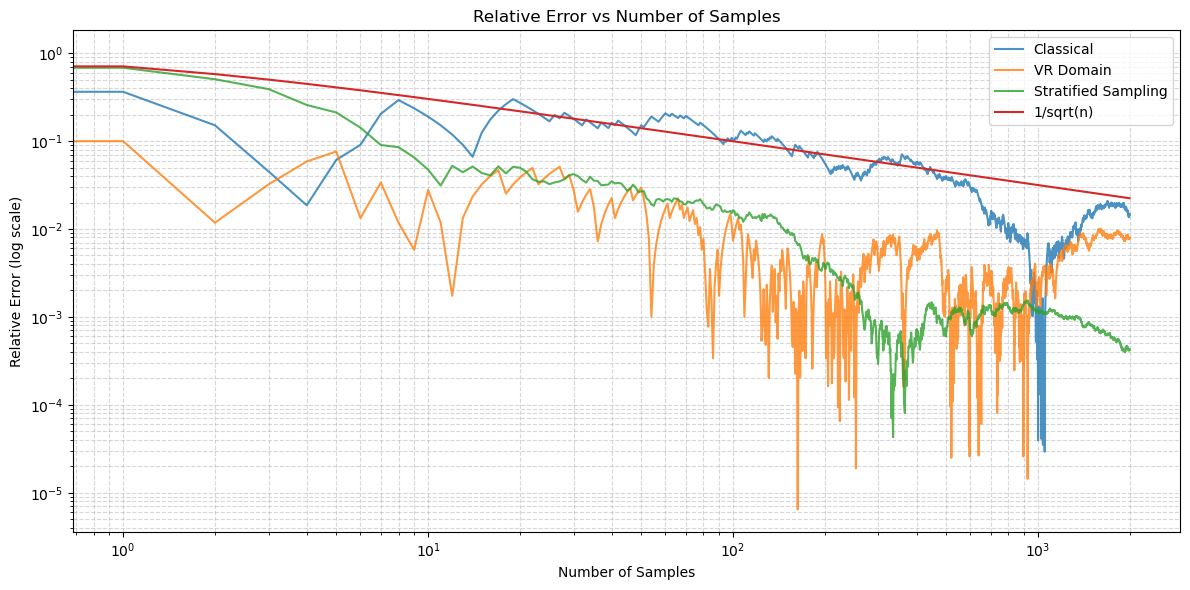

In [88]:
plot_relative_error(pi_estimator, 2000)

#### Stratified sampling visualization

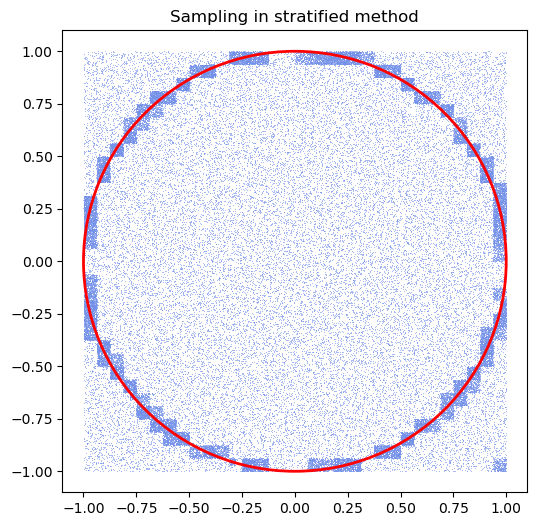

In [92]:
pi_estimator = PiEstimator(radius = 1)
pi_estimator.stratified_sampling_estimate(100_000, min_samples = 30, max_depth = 10)
pi_estimator.plot_stratified_samples_circle()

All three methods together.

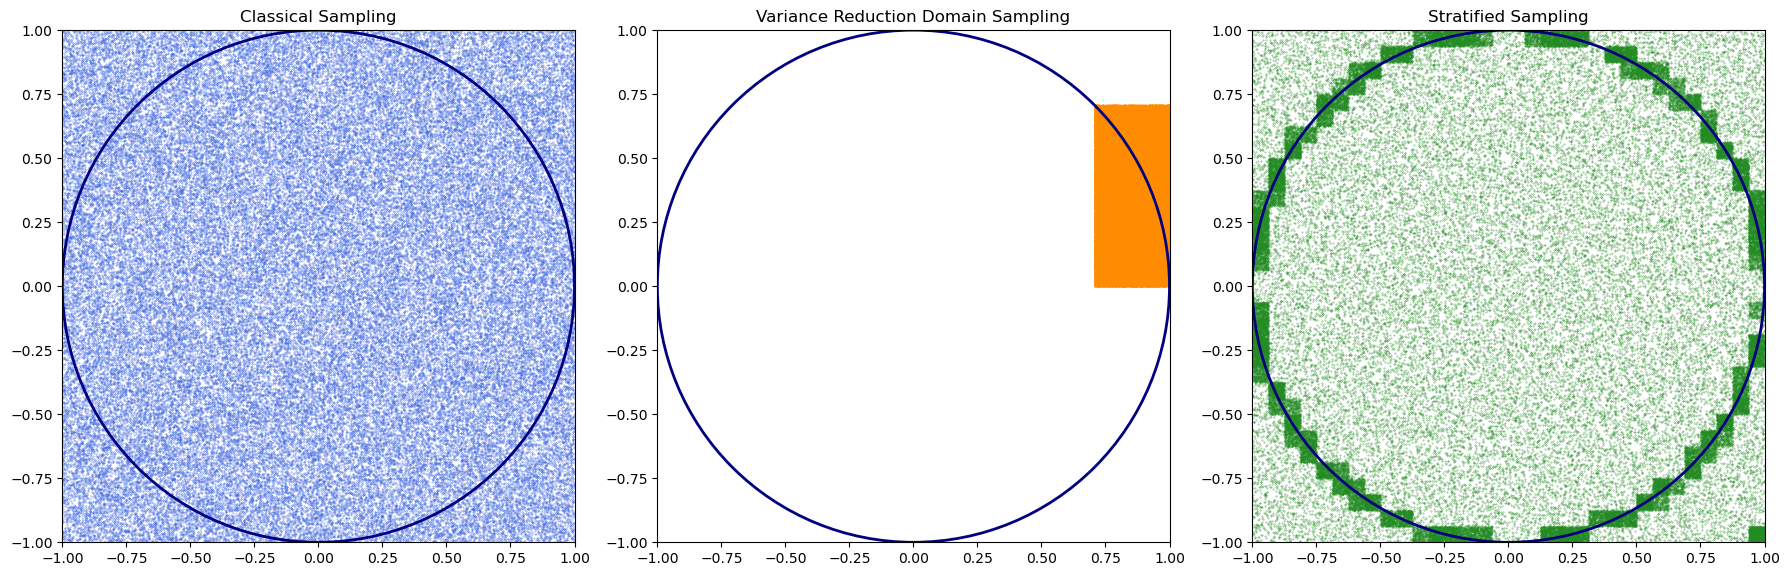

In [26]:
pi_estimator = PiEstimator(radius = 1)
n = 100_000
pi_estimator.classical_estimate(n)
pi_estimator.vr_domain_estimate(n)
pi_estimator.stratified_sampling_estimate(n, min_samples = 30)
pi_estimator.plot_all_samples()

### Other functions

1. Square: identifier on $[-1, 1] \times [-1, 1]$. True integration value: 4.

Estimated value: 4.0000


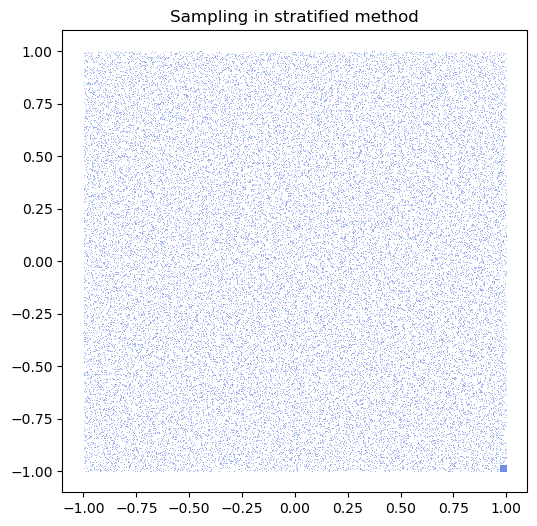

In [93]:
def f_square(x: np.ndarray, y: np.ndarray, radius) -> np.ndarray:
    return np.ones_like(x)

estimator = PiEstimator(radius=1)
val = estimator.stratified_sampling_estimate(N = 50_000, function = f_square, min_samples = 10, max_depth = 10, eps = 0.000001)
print(f"Estimated value: {val:.4f}")

estimator.plot_stratified_samples_circle(circle = False)


2. Gaussian function centered at origin: $e^{x^2 + y^2}$ on $[-1, 1] \times [-1, 1]$. True value: ~2.23 (integral calculator). (DeepSeek recommendation).

Estimated value: 2.2301


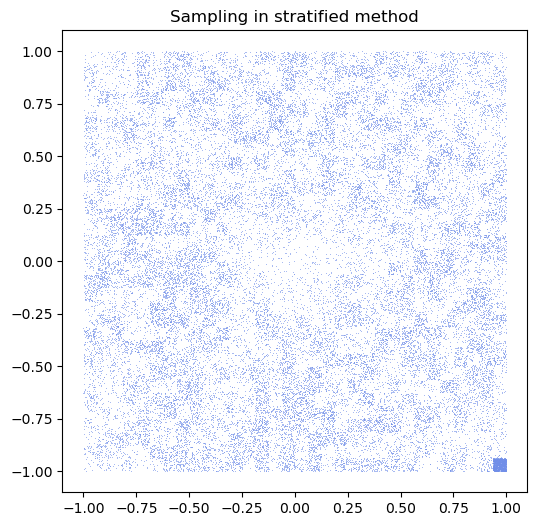

In [94]:
def f_gaussian(x: np.ndarray, y: np.ndarray, radius) -> np.ndarray:
    return np.exp(-(x**2 + y**2))

estimator = PiEstimator(radius=1)
val = estimator.stratified_sampling_estimate(N = 50_000, function = f_gaussian, min_samples = 10, max_depth = 10, eps = 0.000001)
print(f"Estimated value: {val:.4f}")

estimator.plot_stratified_samples_circle(circle = False)

Now, let's sample using stratified method and not estimate any integral, but draw some shapes. Code below is generated with DeepSeek (verified by me).

In [98]:
def club(x, y, radius):
    # Scale coordinates to fit within the radius
    x_scaled = x / radius
    y_scaled = y / radius
    
    # Club shape: three circles and a stem
    # Main circle (center)
    main_circle = (x_scaled**2 + (y_scaled - 0.3)**2) <= 0.3**2
    
    # Left circle
    left_circle = ((x_scaled + 0.25)**2 + (y_scaled + 0.25)**2) <= 0.3**2
    
    # Right circle
    right_circle = ((x_scaled - 0.25)**2 + (y_scaled + 0.25)**2) <= 0.3**2
    
    # Stem (rectangle)
    stem = (np.abs(x_scaled) <= 0.1) & (y_scaled >= -0.8) & (y_scaled <= 0.3)
    
    mask = main_circle | left_circle | right_circle | stem
    return mask.astype(float)

def diamond(x, y, radius):
    # Scale coordinates to fit within the radius
    x_scaled = x / radius
    y_scaled = y / radius
    
    # Diamond shape: a rotated square (|x| + |y| <= 1)
    mask = (np.abs(x_scaled) + np.abs(y_scaled)) <= 1
    return mask.astype(float)


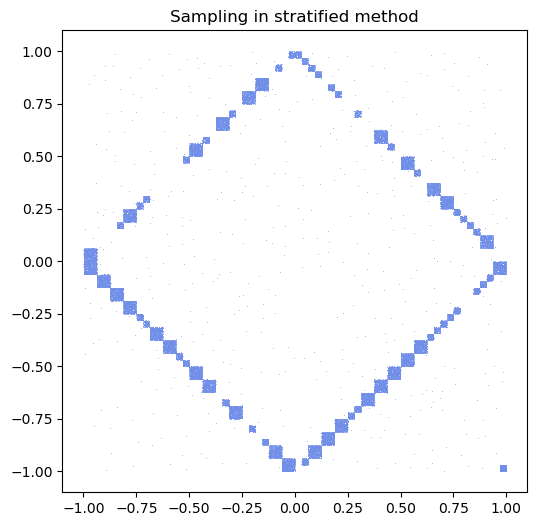

In [99]:
diamond_est = PiEstimator(radius = 1)
diamond_est.stratified_sampling_estimate(N = 50_000, function = diamond, min_samples = 10, max_depth = 10, eps = 0.000001)
diamond_est.plot_stratified_samples_circle(circle= False)

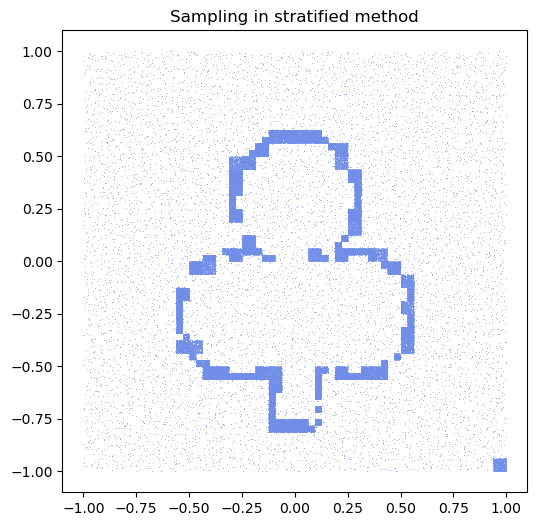

In [74]:
club_est = PiEstimator(radius = 1)
club_est.stratified_sampling_estimate(N = 100_000, function = club, min_samples = 20, max_depth = 10, eps = 0.00001)
club_est.plot_stratified_samples_circle(circle= False)

#### Conclusions and notes:
- Stratified sampling always results in the lowest variance (standard deviation, confidence interval length, convergence plots, boxplots). Although, utilizing domain knowledge and redesigning the sampling strategy lowers the variance as well.
- On some pictures of stratified method, there is a small, very intensive square in the bottom right corner. It is a result of code line in algorithm, which ensures that all samples are used (we want to use our budget as much as possible). 
```python
n_samples_region[0] += N - np.sum(n_samples_region) # so that all samples are well used
```
- Lowering smoothing parameter in strtified sampling (`eps`) results in significantly more samples around function edge.
- Lowering `max_depth` parameter thins the "edges".
- The most preferable approach is stratified sampling, however it has the highesr execution time due to recursive approach.
- **Any variance reduction method reduces variance.**

---

### Integral estimation

Our task is to estimate integral 

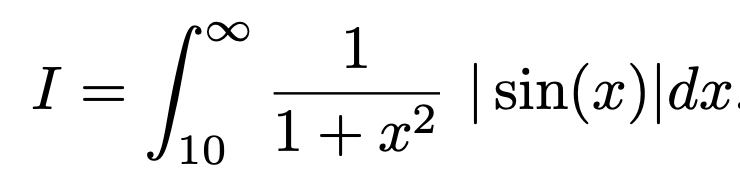

Firstly, let's calculate its "accurate" value. In order to do so, we will use Integrate package from SciPy library.

In [17]:
from scipy.integrate import quad 

f = lambda x: np.abs(np.sin(x)) /  (1 + x **2)
I, err = quad(f, 10, np.inf)
print(f"Estimation: {I}, error: {err}")

Estimation: 0.06549777508158958, error: 0.0053866670709461495


Four methods are implemented:
- Cauchy distribution (`method_A`)
- Importance sampling (`method_B`)
- Control variates idea I (`method_C`)  
Let $f(X) = \frac{|sin(x)|}{1+x^2}$, then we can estimate that $I = \int_{10}^b \frac{|sin(x)|}{1+x^2} dx$ with $b \rightarrow \infty$. In control variates method, let $$f(X) = \frac{|sin(x)|}{1+x^2}$$ and $$k(x) = \frac{1}{1 + x^2}$$ and we will sample $X_1,...,X_n \sim U(10, b)$ with $b \rightarrow \infty$.  
The expected value of $k(X)$ is $\mathbb{E}[k(X)] = arctan(b) - arctan(10)$ with $b \rightarrow \infty$. In practice, we will simply set $b$ to a big integer, like 10 000 or more. It is reasonable, ale $|arctan(10 000) - arctan(\infty)| \approx 10^{-5}$ (see: cell below).

- Integration by substitution with $x = y/10$ (`method_D`)  
$\int_{10}^{\infty} \frac{1}{1+x^2}|sin(x)| \,dx = 10 \int_{0}^{1} \frac{1}{100 + y^2}|sin(\frac{10}{y})| \,dy$

In [5]:
np.pi/2 - np.arctan(10_000)

9.999999966670003e-05

In [ ]:
def method_A(n, cumulative=False):
    """
    Estimates the integral using the Cauchy distribution.

    Args:
        n (int): Number of samples.
        cumulative (bool, optional): If True, returns cumulative estimates. Defaults to False.

    Returns:
        float or np.ndarray: The estimated integral value or cumulative estimates.
    """
    x = np.random.standard_cauchy(size=n)
    vals = (x >= 10) * np.abs(np.sin(x)) * np.pi

    if cumulative:
        return np.cumsum(vals) / np.arange(1, n + 1)

    return np.mean(vals)


def method_B(n, cumulative=False):
    """
    Estimates the integral using importance sampling.

    Args:
        n (int): Number of samples.
        cumulative (bool, optional): If True, returns cumulative estimates. Defaults to False.

    Returns:
        float or np.ndarray: The estimated integral value or cumulative estimates.
    """
    sample = 10 + np.random.standard_cauchy(size=2 * n)
    sample = sample[sample >= 10]
    weights = (np.abs(np.sin(sample)) * ((sample - 10) ** 2 + 1)) / (1 + sample**2) * np.pi
    cumulative_sum = np.cumsum(weights)
    counts = np.arange(1, len(sample) + 1)
    estimates = 0.5 * cumulative_sum / counts

    if cumulative:
        return estimates
    return estimates[-1]


def method_C(n, cumulative=False):
    """
    Estimates the integral using control variates.

    Args:
        n (int): Number of samples.
        cumulative (bool, optional): If True, returns cumulative estimates. Defaults to False.

    Returns:
        float or np.ndarray: The estimated integral value or cumulative estimates.
    """
    assert n > 10
    lb, ub = 10, n
    mu = np.arctan(ub) - np.arctan(lb)
    ests = np.zeros(n)

    for i in range(1, n + 1):
        u = np.random.uniform(lb, ub, size=i)
        f = np.abs(np.sin(u)) / (1 + u**2)
        k = 1 / (1 + u**2)
        ests[i - 1] = mu + (ub - lb) * np.mean(f - k)

    if cumulative:
        return np.cumsum(ests) / np.arange(1, n + 1)

    return ests[-1]


def method_D(n, cumulative=False):
    """
    Estimates the integral using substitution.

    Args:
        n (int): Number of samples.
        cumulative (bool, optional): If True, returns cumulative estimates. Defaults to False.

    Returns:
        float or np.ndarray: The estimated integral value or cumulative estimates.
    """
    u = np.random.uniform(0, 1, size=n)
    vals = 10 * np.abs(np.sin(10 / u)) / (u**2 + 100)

    if cumulative:
        return np.cumsum(vals) / np.arange(1, n + 1)
    return np.mean(vals)


#### Convergence comparison

Estimations convergence comparison

In [70]:
def plot_integral_estimations_convergence(n, k, seed = 42):
    assert n > k
    
    np.random.seed(42)
    
    x = range(0, n)
    y = method_A(n, cumulative = True)
    b = method_B(n, cumulative = True)
    c = method_C(n, cumulative = True)
    z = method_D(n, cumulative = True)


    plt.figure(figsize=(20,10))
    sns.lineplot(x = x[k:], y = y[k:], label = "A: Cauchy distribution")
    sns.lineplot(x = range(k, len(b)), y = b[k:], label = "B: importance sampling")
    sns.lineplot(x = x[k:], y = c[k:], label = "C: control variates")
    sns.lineplot(x = x[k:], y = z[k:], label = "D: integrating by subsitution")
    plt.hlines(xmin = k, xmax = n - 1, y = 0.06549777508158958, color = "black", label = "SciPy Integrate Value")
    plt.title("Integral estimations convergence.")
    plt.xlabel(f"Number of samples (> {k})")
    plt.ylabel("Integral estimation")
    plt.legend(title="Method")
    plt.show();

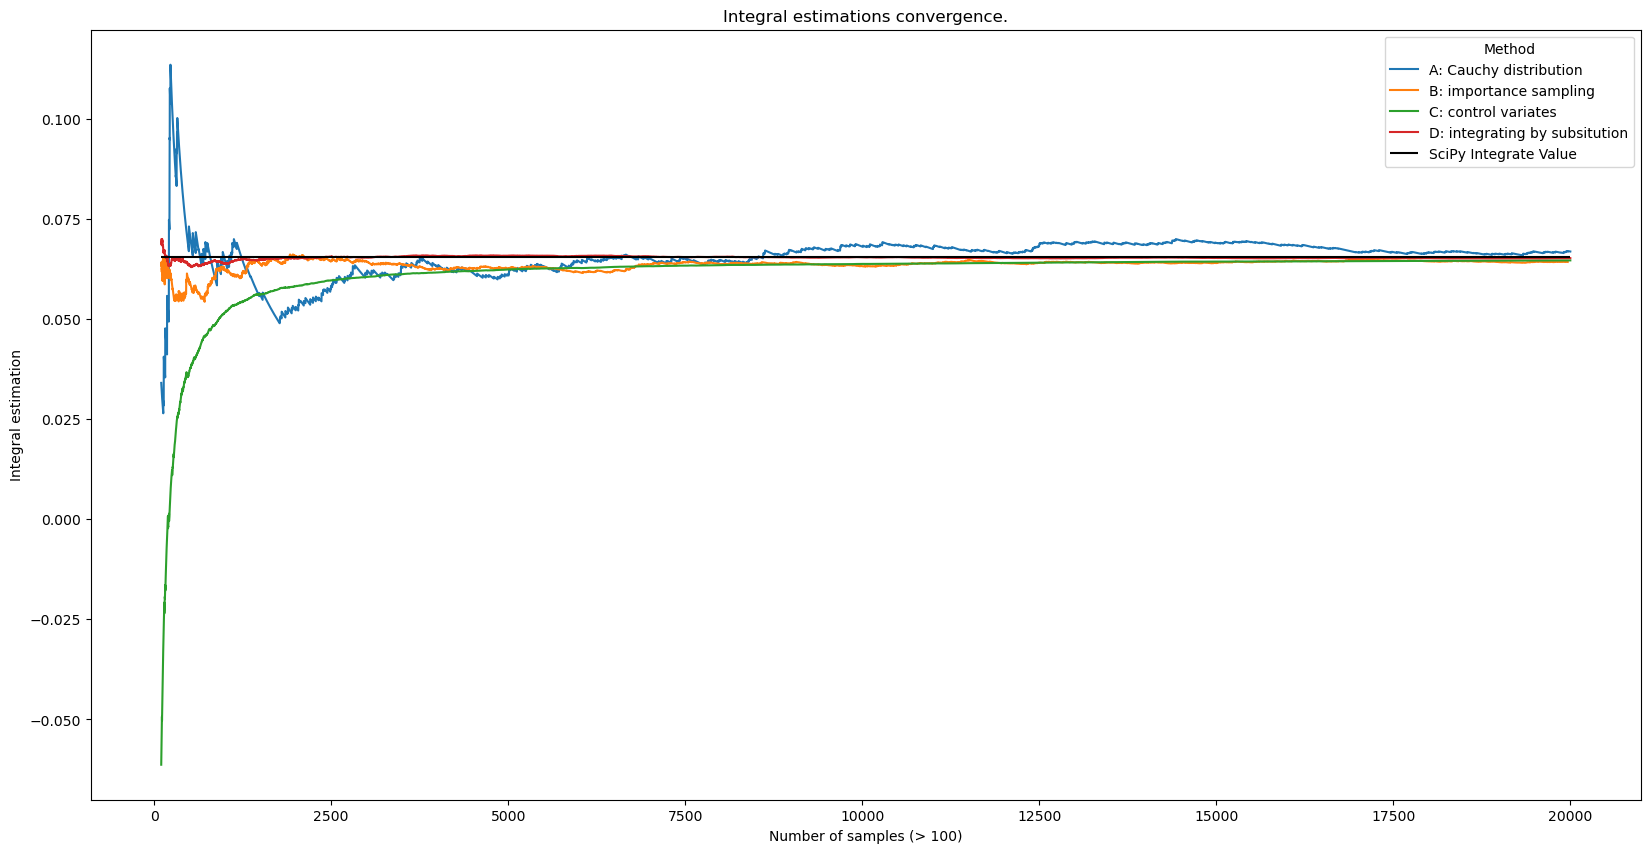

In [71]:
plot_integral_estimations_convergence(20_000, 100)

... and let's zoom the furthest to the right values

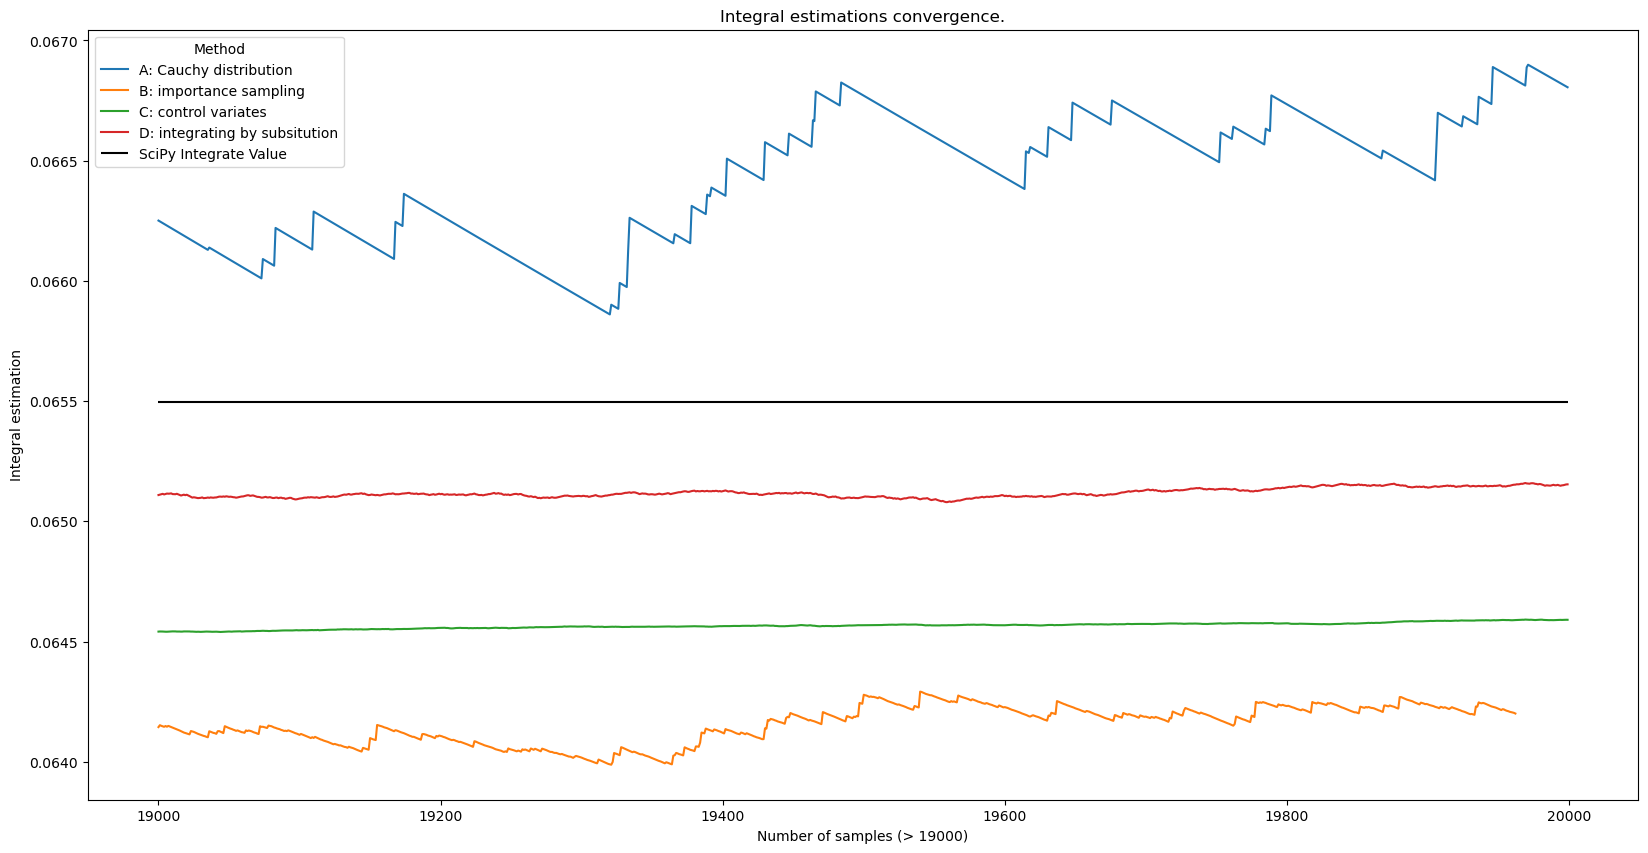

In [72]:
plot_integral_estimations_convergence(20_000, 19_000)

From this plot, that the most favorable method is integrating by substitution (D), followed by control variates (C) and then importance sampling.

#### Boxplots analysis

In [89]:
def integral_boxplots(n_trials = 1000, n_samples = 1000):
    results_A = np.array([method_A(n_samples) for _ in range(n_trials)])
    results_B = np.array([method_B(n_samples) for _ in range(n_trials)])
    results_C = np.array([method_C(n_samples) for _ in range(n_trials)])
    results_D = np.array([method_D(n_samples) for _ in range(n_trials)])
    
    data = pd.DataFrame({
        "A: Cauchy distribution": results_A,
        "B: importance sampling": results_B,
        "C: control variates": results_C,
        "D: intergating by substitution": results_D
    })
    
    plt.figure(figsize=(10,6))
    sns.boxplot(data=data)
    plt.axhline(I, linestyle="--", color="red", label="SciPy Intergate Value")
    plt.title("Boxplot: results of integral estimations")
    plt.ylabel("Estimated integral Value")
    plt.legend()
    plt.grid(True)
    plt.show()

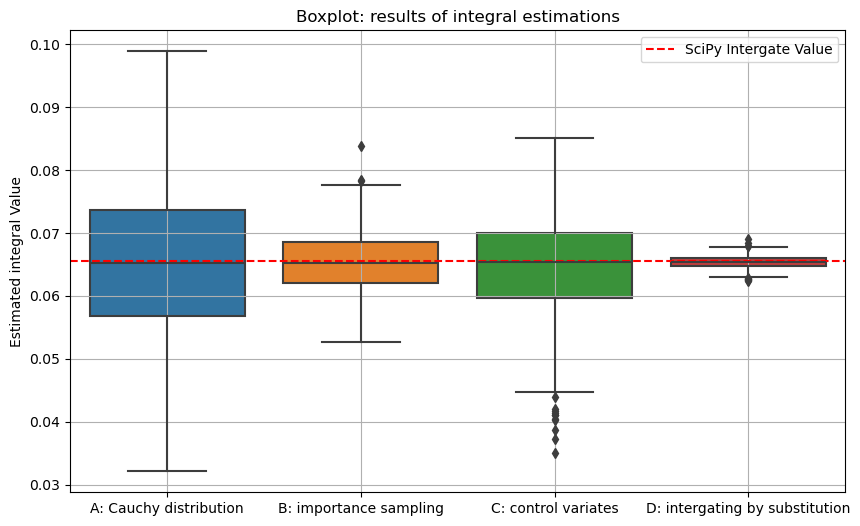

In [90]:
integral_boxplots()

#### Confidence intervals comparison

In [76]:
def conf_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))
    margin = norm.ppf((1 + confidence) / 2) * std_err
    return mean - margin, mean + margin

In [91]:
def compare_confidence_intervals(n_trials = 10_000, n_samples = 1000, confidence = 0.95):
    results_A = np.array([method_A(n_samples) for _ in range(n_trials)])
    results_B = np.array([method_B(n_samples) for _ in range(n_trials)])
    results_C = np.array([method_C(n_samples) for _ in range(n_trials)])
    results_D = np.array([method_D(n_samples) for _ in range(n_trials)])
    
    ci_A = conf_interval(results_A, confidence)
    ci_B = conf_interval(results_B, confidence)
    ci_C = conf_interval(results_C, confidence)
    ci_D = conf_interval(results_D, confidence)
    
    print(f"Confidence intervals with confidence level = {confidence:.4f}")
    print(f"Confidence interval for method A: ({ci_A[0]:.4f}, {ci_A[1]:.4f}), width = {ci_A[1] - ci_A[0]:.4f}.")
    print(f"Confidence interval for method B: ({ci_B[0]:.4f}, {ci_B[1]:.4f}), width = {ci_B[1] - ci_B[0]:.4f}.")
    print(f"Confidence interval for method C: ({ci_C[0]:.4f}, {ci_C[1]:.4f}), width = {ci_C[1] - ci_C[0]:.4f}.")
    print(f"Confidence interval for method D: ({ci_D[0]:.4f}, {ci_D[1]:.4f}), width = {ci_D[1] - ci_D[0]:.4f}.")
    
    widths = [ci_A[1] - ci_A[0], ci_B[1] - ci_B[0], ci_C[1] - ci_C[0], ci_D[1] - ci_D[0]]
    methods = ['A (Cauchy dist.)', 'B (importance sampling)', 'C (control variates)',  'D (int. by substitution)']
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=methods, y=widths, palette="tab10")
    plt.title("Width of Confidence Intervals for Different Methods")
    plt.xlabel("Method")
    plt.ylabel("Width of Confidence Interval")
    plt.show()
    

Confidence intervals with confidence level = 0.9500
Confidence interval for method A: (0.0645, 0.0660), width = 0.0015.
Confidence interval for method B: (0.0653, 0.0659), width = 0.0006.
Confidence interval for method C: (0.0643, 0.0653), width = 0.0009.
Confidence interval for method D: (0.0653, 0.0654), width = 0.0001.


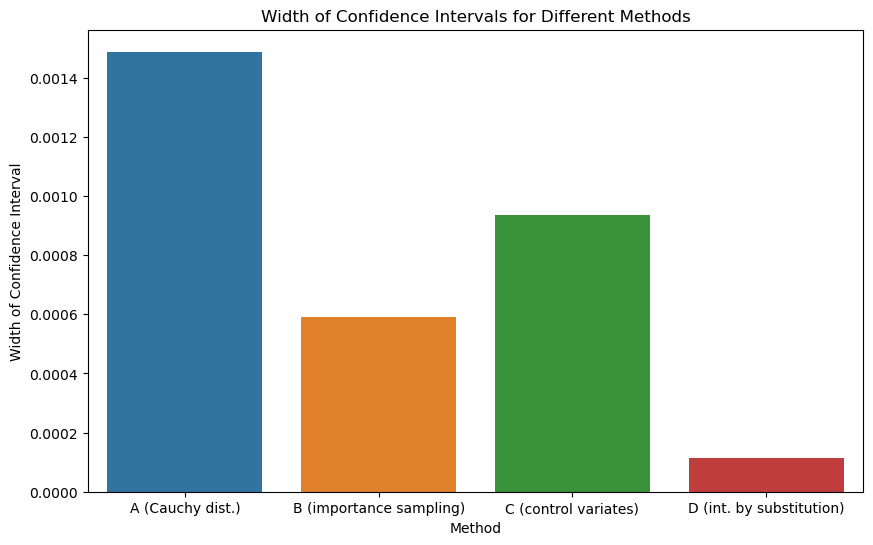

In [92]:
compare_confidence_intervals(n_trials = 1000)

The difference in widths of confidence intervals suggests that importance sampling may be better solution.

#### Samples histograms

Note: colors for methods B and C are swapped for better visualization.

In [95]:
def plot_methods_histograms(n_trials = 10_000, n_samples = 1000):
    results_A = np.array([method_A(n_samples) for _ in range(n_trials)])
    results_B = np.array([method_B(n_samples) for _ in range(n_trials)])
    results_C = np.array([method_C(n_samples) for _ in range(n_trials)])
    results_D = np.array([method_D(n_samples) for _ in range(n_trials)])
    
    plt.figure(figsize=(10, 6))
    sns.histplot(results_A, color="blue", label="Method A: Cauchy distribution", kde=True, alpha=0.5, bins=50)
    sns.histplot(results_B, color="green", label="Method B: Importance sampling", kde=True, alpha=0.5, bins=50)
    sns.histplot(results_C, color="orange", label="Method C: Control variates", kde=True, alpha=0.5, bins=50)
    sns.histplot(results_D, color="red", label="Method D: Integration by substitution", kde=True, alpha=0.5, bins=50)
    plt.axvline(I, color="black", linestyle="--", label="SciPy Integrate Value")
    plt.title("Histograms of Methods' Results")
    plt.xlabel("Estimated Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

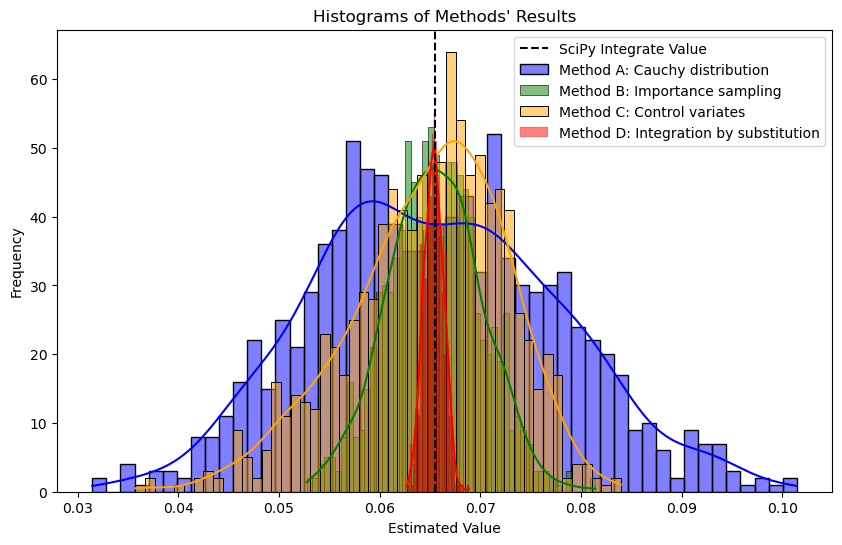

In [96]:
plot_methods_histograms(n_trials = 1000)

#### Conclusions and notes:
- Any variance reduction method positively impacts on results compared to straightforward sampling from Cauchy dist.
- The best method, according to all performed tests is integrating by substitution, followed by importanve sampling. Poorer performance of control variates may be due to bias which appears with sampling from U(10, b). 